In [25]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.optimize import minimize
from numpy.random import choice, rand
from numpy.lib import pad
from math import sqrt, floor, ceil
from sklearn.neural_network import MLPClassifier

### 1.1 Visualizing the data

In [2]:
def load_data(file):
    return loadmat(file)

In [3]:
data = load_data('./ex4data1.mat')
X = data['X']
# y = np.array(list(map(lambda a: [0] if a[0] == 10 else a, data['y'])))
y = data['y']
print(X.shape)
print(y.shape)

(5000, 400)
(5000, 1)


In [4]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array looks like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))


def unblockshaped(arr, h, w):
    """
    Return an array of shape (h, w) where
    h * w = arr.size

    If arr is of shape (n, nrows, ncols), n sublocks of shape (nrows, ncols),
    then the returned array preserves the "physical" layout of the sublocks.
    """
    n, nrows, ncols = arr.shape
    return (arr.reshape(h//nrows, -1, nrows, ncols)
               .swapaxes(1,2)
               .reshape(h, w))

def pad_with_ones(vector, pad_width, iaxis, kwargs):
    vector[:pad_width[0]] = 1
    vector[-pad_width[1]:] = 1
    return vector

def display_data(data):
    imgs = np.array([pad(data[i].reshape(20, 20).T, 1, pad_with_ones) for i in range(len(data))])
    
    m, height, width = imgs.shape
    n_row = floor(sqrt(m))
    n_col = ceil(m/n_row)
    
    imgs = unblockshaped(imgs, n_row*imgs.shape[1], n_col*imgs.shape[2])
    
    plt.gray()
    plt.imshow(imgs)

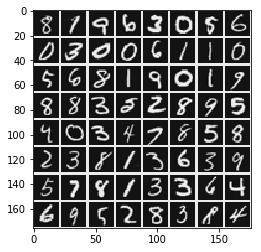

In [5]:
sample_data = X[choice(X.shape[0], 64, replace=False)]
# sample_data = X[0:64]
display_data(sample_data)

### 1.2 Model representation

In [6]:
weights = load_data('./ex4weights.mat')
theta_1 = weights['Theta1']
theta_2 = weights['Theta2']
print(theta_1.shape)
print(theta_2.shape)

(25, 401)
(10, 26)


### 1.3 Feedforward and cost function

In [7]:
def sigmoid(x, derivative=False):
    return sigmoid(x)*(1-sigmoid(x)) if derivative else 1/(1+np.exp(-x))

In [8]:
def unroll(theta1, theta2):
    return np.r_[theta1.flatten(), theta2.flatten()]

def roll(nn_params, input_layer_size, hidden_layer_size, num_labels):
    theta_1 = nn_params[:hidden_layer_size*(input_layer_size+1)].reshape(hidden_layer_size, input_layer_size+1)
    theta_2 = nn_params[hidden_layer_size*(input_layer_size+1):].reshape(num_labels, hidden_layer_size+1)

    return theta_1, theta_2

In [9]:
def feedforward(X, theta_1, theta_2):
    a1 = np.c_[np.ones((X.shape[0],1)), X] # 5000*401
    
    z2 = a1.dot(theta_1.T) # 5000*25
    a2 = np.c_[np.ones((X.shape[0],1)), sigmoid(z2)] # 5000*26
    
    z3 = a2.dot(theta_2.T) # 5000*10
    a3 = sigmoid(z3) # 5000*10
    
    return a3

In [10]:
def nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamb):
    # Part 1,3 Feedforward
    m = len(y)
    theta_1, theta_2 = roll(nn_params, input_layer_size, hidden_layer_size, num_labels)
    hx = feedforward(X, theta_1, theta_2)

    y_matrix = pd.get_dummies(y.ravel()).values # 5000*10
    
    # Outer product since y_matrix is dummy matrix
    J = -1*(1/m)*np.sum(y_matrix*np.log(hx) + (1-y_matrix)*np.log(1-hx)) + \
        (lamb/(2*m))*(np.sum(np.square(theta_1[:,1:])) + np.sum(np.square(theta_2[:,1:])))
    
    return J

In [11]:
def nn_gradient(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamb):
    m = len(y)
    theta_1, theta_2 = roll(nn_params, input_layer_size, hidden_layer_size, num_labels)

    a1 = np.c_[np.ones((X.shape[0],1)), X] # 5000*401
    
    z2 = a1.dot(theta_1.T) # 5000*25
    a2 = np.c_[np.ones((X.shape[0],1)), sigmoid(z2)] # 5000*26
    
    z3 = a2.dot(theta_2.T) # 5000*10
    a3 = sigmoid(z3) # 5000*10
    
    y_matrix = pd.get_dummies(y.ravel()).values # 5000*10
    
    d3 = a3 - y_matrix # 5000*10
    d2 = d3.dot(theta_2[:,1:])*sigmoid(z2, True) # 5000*25

    delta_1 = d2.T.dot(a1) # 25*401
    delta_2 = d3.T.dot(a2) # 10*26
    
    theta1_ = np.c_[np.ones((theta_1.shape[0], 1)), theta_1[:,1:]] # 25*401
    theta2_ = np.c_[np.ones((theta_2.shape[0], 1)), theta_2[:,1:]] # 10*26

    theta1_grad = delta_1/m + (lamb/m)*theta1_
    theta2_grad = delta_2/m + (lamb/m)*theta2_
    
    return unroll(theta1_grad, theta2_grad)

In [12]:
nn_params = unroll(theta_1, theta_2)
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

In [13]:
J = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamb=0)
print(J)

0.2876291651613189


In [14]:
J = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamb=1)
print(J)

0.38376985909092365


### 2.2 Random initialization

In [15]:
def rand_initialize_weights(l_in, l_out):
    epsilon_init = np.sqrt(6)/np.sqrt(l_in+l_out)
    return rand(l_out, 1+l_in).astype(np.float128)*2*epsilon_init - epsilon_init

In [16]:
theta_1_init = rand_initialize_weights(400,25)
theta_2_init = rand_initialize_weights(25,10)
print(theta_1_init.shape)
print(theta_2_init.shape)

(25, 401)
(10, 26)


### 2.4 Gradient checking

In [17]:
def compute_numerical_gradient(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamb):
    m = len(nn_params)
    numgrad = np.zeros(m)
    perturb = np.zeros(m)
    e = 1e-4
    for p in range(m):
        # Set perturbation vector
        perturb[p] = e

        loss1 = nn_cost_function(nn_params - perturb, input_layer_size, hidden_layer_size, num_labels, X, y, lamb)
        loss2 = nn_cost_function(nn_params + perturb, input_layer_size, hidden_layer_size, num_labels, X, y, lamb)
        numgrad[p] = (loss2 - loss1)/(2*e)
        perturb[p] = 0
    
    return numgrad

In [18]:
def check_nn_gradients(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamb=1):
    grad = nn_gradient(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamb=1)
    numgrad = compute_numerical_gradient(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamb)
    
    diff = grad - numgrad
    print(diff[:10])
    plt.plot(diff, label='diff')
    plt.legend()
    plt.show()

[ 4.99999999e-02 -3.07409005e-11 -3.24012050e-11 -6.31294897e-12
  4.87632482e-12 -9.15981190e-13  3.51349465e-11  3.51243770e-12
 -2.63364255e-11 -6.11150276e-11]


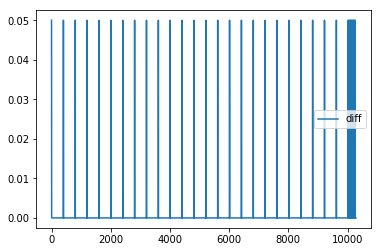

In [19]:
check_nn_gradients(nn_params, input_layer_size, hidden_layer_size, num_labels, X[:20], y[:20], lamb=1)

### 2.6 Learning parameters

In [20]:
nn_params_init = unroll(theta_1_init, theta_2_init)
res = minimize(nn_cost_function, nn_params_init, method='CG', jac=nn_gradient, \
               args=(input_layer_size, hidden_layer_size, num_labels, X, y, 1), options={'maxiter': 200,'disp': True})

         Current function value: 0.335960
         Iterations: 200
         Function evaluations: 521
         Gradient evaluations: 521


In [21]:
print(res.x)

[-1.00781796e+00  1.25763507e-03  1.49984043e-03 ...  9.82986046e-01
  8.41458377e-01  4.78436084e+00]


In [22]:
def predict_nn(nn_params, X):
    theta_1, theta_2 = roll(nn_params, input_layer_size, hidden_layer_size, num_labels)

    a3 = feedforward(X, theta_1, theta_2)
    pred = np.argmax(a3, axis=1)+1 # 5000*1
    
    return pred.flatten()

def evaluate(ground_truth, prediction):
    return np.mean(ground_truth.ravel() == prediction)

In [23]:
pred = predict_nn(res.x, X)
evaluate(y, pred)

0.9914

### 3 Visualizing the hidden layer

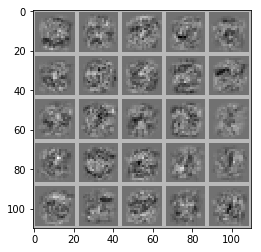

In [24]:
theta1_trained, theta2_trained = roll(res.x, input_layer_size, hidden_layer_size, num_labels)
display_data(theta1_trained[:,1:].astype(np.float64))

### Extra. sklearn implementation

In [27]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(25,10), random_state=1)
clf.fit(X, y.ravel())

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(25, 10), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [28]:
sk_pred = clf.predict(X)
evaluate(y, sk_pred)

1.0